![](https://img.kaikeba.com/web/kkb_index/img_index_logo.png)

# Lesson-02 Assignment

   本周课程主要包含了图像基本操作中的卷积/滤波，以及最基础的特征描述算法————Harris Corner和SIFT。希望大家认真复习，理解图像求导/卷积的目的，以及特征的本质。
   本次作业分为阅读部分和算法部分。

## 本次作业的内容

### [Reading]:

You needn't finish reading all of them in just one week!
It's just good for you to know what's happening in this area and to figure out how people try to improve SIFT.

You needn't to remember all of them. 
But please DO REMEMBER procedures of SIFT and HoG. For those who're interested in SLAM, Orb is your inevitable destiny.

1. [optional] Bilateral Filter: https://blog.csdn.net/piaoxuezhong/article/details/78302920
2. Feature Descriptors:
   [Compulsory]
   Hog: https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
   SURF: https://www.vision.ee.ethz.ch/~surf/eccv06.pdf
   [optional]
   BRISK: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.371.1343&rep=rep1&type=pdf
   Orb: http://www.willowgarage.com/sites/default/files/orb_final.pdf [Compulsory for SLAM Guys]
3. Preview parts:
   K-Means: I have no doubts about what you are going to read and where you gonna find the reading materials. There are tons of papers/blogs describing k-means. Just grab one and read.We'll talk about this topic in 3 weeks.

### [Coding]:
Finish 2D convolution/filtering by your self. 
What you are supposed to do can be described as "median blur", which means by using a sliding window on an image, your task is not going to do a normal convolution, but to find the median value within that crop.

You can assume your input has only one channel. (a.k.a a normal 2D list/vector) And you do need to consider the padding method and size. There are 2 padding ways: REPLICA & ZERO. When "REPLICA" is given to you, the padded pixels are same with the border pixels. E.g is [1 2 3] is your image, the padded version will be  [[(...1 1) 1 2 3 (3 3...)]  where how many 1 & 3 in the parenthesis depends on your padding size. When "ZERO", the padded version will be [(...0 0) 1 2 3 (0 0...)]

Assume your input's size of the image is W x H, kernel size's m x n. You may first complete a version with O(W·H·m·n log(m·n)) to O(W·H·m·n·m·n)).

Follow up 1: Can it be completed in a shorter time complexity?

In [127]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [128]:
def getMedian(window, ksize):   #get the median number of the input window
    window = window.flatten()
    window.sort()
    return window[ksize**2//2]

def medianBlur(img, ksize, padding_way='zero'):
    row,col = img.shape
    tck = ksize // 2      # thickness of the padding
    row_n = row + tck * 2  
    col_n = col + tck * 2

    if padding_way == 'zero': 
        img_padding = np.zeros((row_n, col_n))   #initialize the padding image
        img_padding[tck:row_n-tck, tck:col_n-tck] += img
#   if padding_way == 'replica':
#       img_padding = np.zeros((row_n, col_n))
#       img_padding[tck:row_n-tck, tck:col_n-tck] += img    
    img_medianBlur = np.zeros((row, col))  #initialize the output image
    for i in range(row):
        for j in range(col):
            window = img_padding[i:i+ksize, j:j+ksize]
            median = getMedian(window, ksize)
            img_medianBlur[i, j] = median
            
    return img_medianBlur

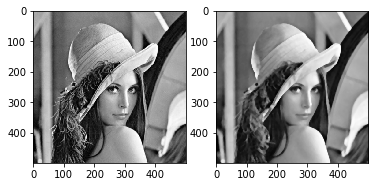

In [133]:
img = plt.imread('lenna.jpg')
img.shape
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

ksize = 7
img_medianBlur = medianBlur(img_gray,ksize)

plt.subplot(121)
plt.imshow(img_gray,cmap='gray') 
plt.subplot(122)
plt.imshow(img_medianBlur,cmap='gray')  

### [Reading + Pseudo Code]:
We haven't told RANSAC algorithm this week. So please try to do the reading.

And now, we can describe it here:
    We have 2 sets of points, say, Points A and Points B. We use A.1 to denote the first point in A, B.2 the 2nd point in B and so forth. Ideally, A.1 is corresponding to B.1, ... A.m corresponding B.m. However, it's obvious that the matching cannot be so perfect and the matching in our real world is like: 
    A.1-B.13, A.2-B.24, A.3-x (has no matching), x-B.5, A.4-B.24(This is a wrong matching) ...
    The target of RANSAC is to find out the true matching within this messy.
    
Algorithm for this procedure can be described like this:
    1. Choose 4 pair of points randomly in our matching points. Those four called "inlier" (中文： 内点) while others "outlier" (中文： 外点)
    2. Get the homography of the inliers
    3. Use this computed homography to test all the other outliers. And separated them by using a threshold into two parts:
        a. new inliers which is satisfied our computed homography
        b. new outliers which is not satisfied by our computed homography.
    4. Get our all inliers (new inliers + old inliers) and goto step 2
    5. As long as there's no changes or we have already repeated step 2-4 k, a number actually can be computed, times, we jump out of the recursion. The final homography matrix will be the one that we want.

[WARNING!!! RANSAC is a general method. Here we add our matching background to that.]

Your task: please complete pseudo code (it would be great if you hand in real code!) of this procedure.

Python:
def ransacMatching(A, B):
    A & B: List of List

Follow up 1. For step 3. How to do the "test“? Please clarify this in your code/pseudo code
Follow up 2. How do decide the "k" mentioned in step 5. Think about it mathematically!

You are supposed to hand in the code in 1 week.

In [ ]:
## RANSAC伪代码：

Input:
    data - A set of observation points. For linear model, it would be (x1,y1),(x2,y2)...(xn,yn).
    n - Minimum number of data points required to estimate model parameters. For linear model, it should be 2.
    k - Maximum number of iterations allowed in the algorithm.
    t – Threshold value to determine data points that are fit well by model.
    d – Number of close data points required to assert that a model fits well to data.
    
Output:
    bestFit – model parameters which best fit the data (or None if no good model is found)
    
iter = 0
best_model = None
best_err = inf (a very large value to initialize)

while iters < k:
    construct points := choose n points randomly in data to construct model
    current_model := use the chosen inlier points to construct the assume model   
    inlier := initialize the inlier list
        
    for every point in the data(except the construct point):
        if point fits maybeModel with an error smaller than t:
           add this point to inliers 
        
    if the number of elements in inliers is > d:
        err := a measure of how well betterModel fits these points
        if err < best_err then
            best_model := current_model
            best_err := err   
                
    increase iter   
return best_fit

Reference: https://en.wikipedia.org/wiki/Random_sample_consensus

In [506]:
## 实现 RANSAC（linear model）
# threshold: to judge if the point is inliner or outliner; d is the restriction of inliner points
class Ransac():
    def ransacLinear(self, data_x, data_y, iter_n, threshold, d):    
        iter = 0
        k_best = None
        b_best = None
        best_err = float('inf')
        p1, p2 = 0, 0
    
        inliner_x_best = []
        inliner_y_best = []
        while iter < iter_n:
            while p1 == p2:
                p1 = random.randint(0,len(data_x)-1)    # choose different 2 points randomly
                p2 = random.randint(0,len(data_x)-1)                
            k = (data_y[p2] - data_y[p1]) / (data_x[p2] - data_x[p1])  # calculate k and b
            b = data_y[p1] - data_x[p1] * k
            err_p = []
            inliner_x = []
            inliner_y = []
            
            for i in range(0,len(data_x)):
                err_p.append(abs(k * data_x[i] + b - data_y[i]) / data_y[i])
                if err_p[i] < threshold:         # inliner or outliner judge
                    inliner_x.append(data_x[i])
                    inliner_y.append(data_y[i])
            
            if len(inliner_x)/len(data_x) > d:   # judge if there is enough inliner
                err_total = sum(err_p)
                if err_total < best_err:
                    k_best = k
                    b_best = b
                    inliner_x_best = inliner_x
                    inliner_y_best = inliner_y
                    best_err = err_total
            iter += 1
        return k_best, b_best, inliner_x_best, inliner_y_best            

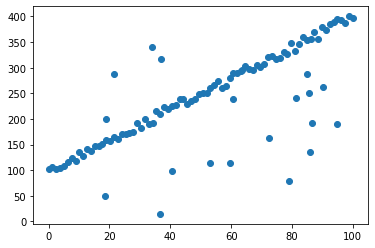

In [509]:
# Construct the data gather

import numpy as np
import random
import matplotlib.pyplot as plt

data_x = np.linspace(0,100,80)
k = 3
b = 100
data_y = k * data_x + b
noise = []
for _ in range(0,80):
    noise.append(random.uniform(-10,10))
data_y += noise   # add noise to data
data_x = data_x.tolist()
data_y = data_y.tolist()
for _ in range(0,20):     # add random points to data
    data_x.append(random.uniform(0,100))
    data_y.append(random.uniform(0,400))

plt.scatter(data_x, data_y)
plt.show()

k = 2.9818911231179914 b = 105.4619942955979


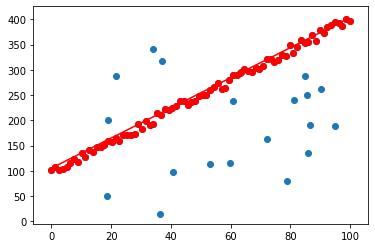

In [516]:
test = Ransac()
k, b, inliner_x, inliner_y = test.ransacLinear(data_x, data_y, 100, 0.15, 0.5)
print('k =', k, 'b =',b)

if k == None:
    print('No good fitting')
else:
    x = np.linspace(0,99,100)
    y = k * x + b
    plt.scatter(data_x, data_y)
    plt.scatter(inliner_x, inliner_y, color='r')
    plt.plot(x, y, color='r')
    plt.show()

### [作业截止时间]

作业能帮助你回顾课堂内容，你又可以通过作业进行代码实操。咱们可要认真、及时的完成作业哦！自布置作业起两周内提交，助教及时批改作业哦～逾期提交不批改。（特殊情况，请找班主任请假。）

这次的作业就到这里了！祝大家学习进步！

![image alt <](http://5b0988e595225.cdn.sohucs.com/images/20190420/1d1070881fd540db817b2a3bdd967f37.gif)